In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
import pickle
%matplotlib inline

from functions import evaluate_model, runtime
from preprocessor_class import Preprocessor

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, log_loss

from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('Data/prepared_text_data_sugar.csv', low_memory = False)

#### Final Models

At this point, I've tested multiple models and tested various hyperparameter values to optimize performance.  The three models chosen are XGBoost, Extra Trees Classifier, and Random Forest Classifier.

Due to time constraints, I did the majority of my hyperparameter tuning using a subset of the full dataset that was about 1/3 the size.  The final models don't need to be iterated upon to find optimal hyperparameter values so I mostly used the values from my testing and defined the model to be used with all data.

In [3]:
start = time.time()

X = df['text']
y = df['sugar_class']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 200)
processor = Preprocessor()
X_train_transformed = processor.fit_transform(X_train_raw)
X_test_transformed = processor.transform(X_test_raw)

vector_pipe = Pipeline([('tfidf', TfidfVectorizer())])
X_train_vector = vector_pipe.fit_transform(X_train_transformed)
X_test_vector = vector_pipe.transform(X_test_transformed)
X_train = pd.DataFrame(X_train_vector.toarray(), columns = vector_pipe['tfidf'].get_feature_names())
X_test = pd.DataFrame(X_test_vector.toarray(), columns = vector_pipe['tfidf'].get_feature_names())

end = time.time()
runtime(start, end)

Runtime: 30.10 seconds


#### Random Forest Classifier

The Random Forest Classifier looks a little different from the cross-validated random search I used in the tuning_and_testing.ipynb notebook.  Some of the hyperparameter values changed when using the full dataset.  Due to time constraints, I was unable to run a full RandomizedSearchCV on the full dataset for all of the values I would have liked to test.  Instead, I focused on the parameters with the highest impact on score.  In particular, n_estimators, min_samples_split, and min_samples_leaf had the greatest effect on the model's predictive capability.  I did some manual tweaking to achieve a score I was satisfied with and did not show a positive improvement by increasing/decreasing the parameters' values.

In [6]:
start = time.time()

rfc = Pipeline([('rfc', RandomForestClassifier(n_estimators = 400,
                                              criterion = 'gini',
                                              max_depth = None,
                                              min_samples_split = 4,
                                              min_samples_leaf = 1,
                                              max_leaf_nodes = None,
                                              max_samples = None,
                                              random_state = 200))])
rfc.fit(X_train, y_train)
evaluate_model(rfc, X_train, X_test, y_train, y_test)

end = time.time()
runtime(start, end)

Weighted F1 Score (Train): 0.9816574144164413
Weighted F1 Score (Test): 0.7686131665290067
Log Loss (Train):  0.2307789964634555
Log Loss (Test):  0.6390098651764874
Runtime: 7 minutes, 36.05 seconds


In [13]:
pickle.dump(rfc, open('Models/randomforest.pkl', 'wb'))

#### XGBoost

XGBoost is the second model that I included.  The score was slightly less than that of the bagging models but it is also a little less overfit.  The RandomizedSearchCV in this case worked well and I used those hyperparameters.

In [7]:
start = time.time()

xgb = Pipeline([('xgb', XGBClassifier(n_estimators = 500,
              learning_rate = 0.274,
              max_depth = 7,
              min_child_weight = 1,
              random_state = 100))])
xgb.fit(X_train, y_train)
evaluate_model(xgb, X_train, X_test, y_train, y_test)

end = time.time()
runtime(start, end)

Weighted F1 Score (Train): 0.9249810125248081
Weighted F1 Score (Test): 0.7592579277430698
Log Loss (Train):  0.3408979071190098
Log Loss (Test):  0.6194830597187826
Runtime: 39 minutes, 42.32 seconds


In [14]:
pickle.dump(xgb, open('Models/xgboost.pkl', 'wb'))

#### Extra Trees Classifier

The final model I chose to use was Extra Trees Classifier.  This ensemble method is quicker and less discriminatory, it is a little less overfit than the Random Forest model.  It performed well and because of feature engineering was relatively simplistic, the random splits of the Extra Trees were sufficient to make decent predictions.

In [8]:
start = time.time()

etc = Pipeline([('etc', ExtraTreesClassifier(n_estimators = 200,
                                             max_features = 'sqrt',
                                             max_samples = 0.5,
                                             bootstrap = True,
                                             random_state = 200))])
etc.fit(X_train, y_train)
evaluate_model(etc, X_train, X_test, y_train, y_test)

end = time.time()
runtime(start, end)

Weighted F1 Score (Train): 0.9767530056965767
Weighted F1 Score (Test): 0.765202367539092
Log Loss (Train):  0.31178909185594295
Log Loss (Test):  0.6695730158180553
Runtime: 8 minutes, 51.97 seconds


In [15]:
pickle.dump(etc, open('Models/extratrees.pkl', 'wb'))

#### Voting Classifier

Although each of these models were improvements over the initial models and performed decently, considering there were 5 classes, I did want to see if I could improve the scores by averaging the benefits and drawbacks to each model.  I used each in a Voting Classifier, which would allow each model to "vote" on the prediction.  This way, if an extraneous random split from Extra Trees were to make a non-sensical classification, the "votes" from the Random Forests and XGBoost would be able to correct it.  Similarly, if XGBoost's gradient nature skipped over an important "step" in its learning process, the other two models may be able to correct it.  Combining the three did improve the scores by a small amount.

In [9]:
start = time.time()

vote = VotingClassifier(estimators = [('rfc', rfc),
                                     ('xgb', xgb),
                                     ('etc', etc)],
                                     voting = 'soft')
vote.fit(X_train, y_train)
evaluate_model(vote, X_train, X_test, y_train, y_test)

end = time.time()
runtime(start, end)

Weighted F1 Score (Train): 0.974173351068141
Weighted F1 Score (Test): 0.7782378607756464
Log Loss (Train):  0.28707556040705257
Log Loss (Test):  0.6153087791388049
Runtime: 47 minutes, 36.20 seconds


In [17]:
pickle.dump(vote, open('Models/voting_classifier.pkl', 'wb'))

In [18]:
start = time.time()

estimators = [('rfc', rfc),
              ('xgb', xgb)]

stack = StackingClassifier(estimators = estimators,
                            final_estimator = etc)
stack.fit(X_train, y_train)
evaluate_model(stack, X_train, X_test, y_train, y_test)

end = time.time()
runtime(start, end)

Weighted F1 Score (Train): 0.9687231796690959
Weighted F1 Score (Test): 0.775903992947241
Log Loss (Train):  0.22042735084257803
Log Loss (Test):  0.6336972885760596
Runtime: 3 hours, 1 minute, 8.39 seconds


In [19]:
pickle.dump(stack, open('Models/stacked_classifier.pkl', 'wb'))

In [4]:
vote = pickle.load(open('Models/stacked_classifier.pkl', 'rb'))

In [5]:
y_pred = vote.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.80      0.86      0.83      1800
           2       0.66      0.61      0.64      1436
           3       0.66      0.65      0.66      1789
           4       0.77      0.77      0.77      2875
           5       0.89      0.91      0.90      2687

    accuracy                           0.78     10587
   macro avg       0.76      0.76      0.76     10587
weighted avg       0.78      0.78      0.78     10587



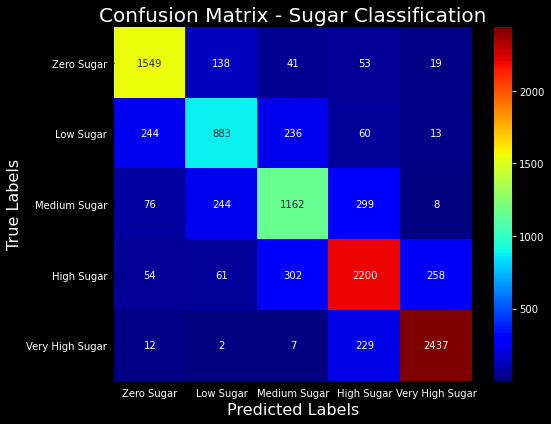

<Figure size 432x288 with 0 Axes>

In [6]:
cm = confusion_matrix(y_test, y_pred)
classes = ['Zero Sugar', 'Low Sugar', 'Medium Sugar', 'High Sugar', 'Very High Sugar']
plt.figure(figsize=(8, 6), facecolor = 'black')
heatmap = sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'jet', xticklabels = classes, yticklabels = classes)
plt.title('Confusion Matrix - Sugar Classification', color='white', fontsize = 20)
plt.xlabel('Predicted Labels', color='white', fontsize = 16)
plt.ylabel('True Labels', color='white', fontsize = 16)
plt.xticks(color='white')
plt.yticks(color='white')
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(color='white')
for label in cbar.ax.yaxis.get_ticklabels():
    label.set_color('white')
cbar.ax.tick_params(color = 'white')

plt.tight_layout()
plt.show()

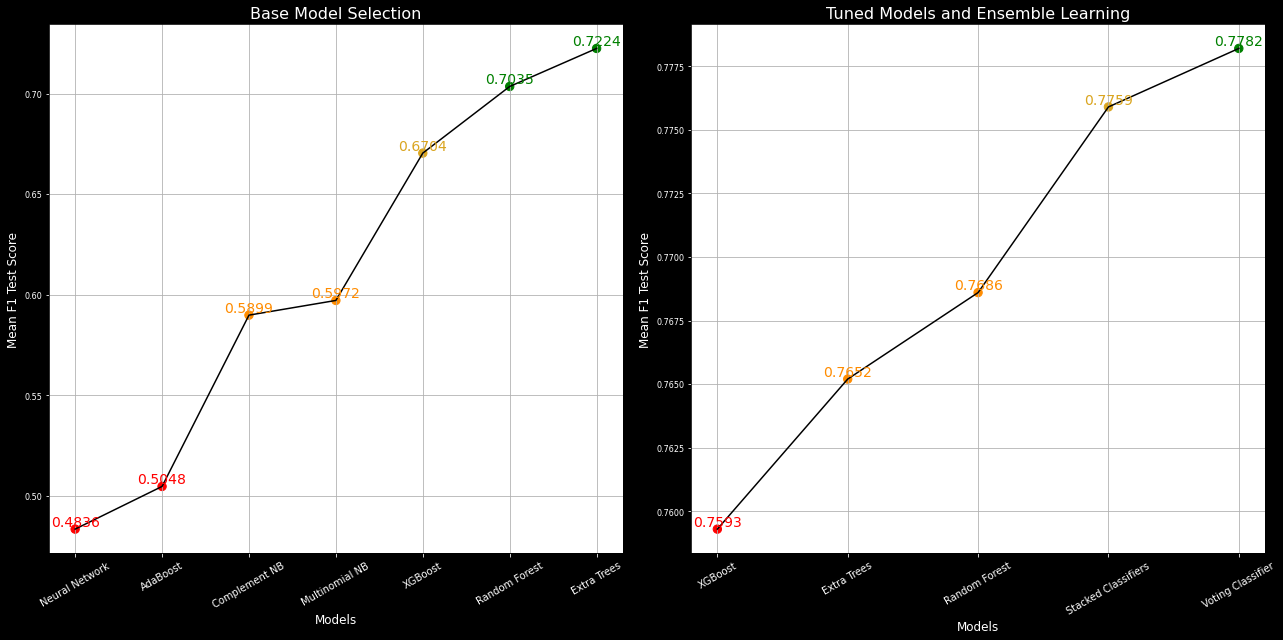

In [109]:
base_models = ['Neural Network', 'AdaBoost', 'Complement NB', 'Multinomial NB', 'XGBoost', 'Random Forest', 'Extra Trees']
base_scores = [0.4836, 0.5048, 0.5899, 0.5972, 0.6704, 0.7035, 0.7224]

final_models = ['XGBoost', 'Extra Trees', 'Random Forest', 'Stacked Classifiers', 'Voting Classifier']
final_scores = [0.7593, 0.7652, 0.7686, 0.7759, 0.7782]

fig, axs = plt.subplots(1, 2, figsize = (18, 9), facecolor = 'black')
colors_bm = ['red', 'red', 'darkorange', 'darkorange', 'goldenrod', 'green', 'green']
axs[0].plot(base_models, base_scores, color = 'black')
axs[0].scatter(base_models, base_scores, color = colors_bm, marker = 'o', s = 70)
axs[0].set_title('Base Model Selection', color = 'White', fontsize = 16)
axs[0].set_xlabel('Models', color = 'white', fontsize = 12)
axs[0].set_ylabel('F1 Test Score', color = 'white', fontsize = 12)
axs[0].tick_params(axis = 'x', rotation = 30, colors = 'white', labelsize = 10)
axs[0].tick_params(axis = 'y', colors = 'white', labelsize = 8)
for i, label in enumerate(base_scores):
    axs[0].text(base_models[i], base_scores[i], label, fontsize = 14, color = colors_bm[i], ha = 'center', va = 'bottom')
axs[0].grid(True)

colors_fm = ['red', 'darkorange', 'darkorange', 'goldenrod', 'green']
axs[1].plot(final_models, final_scores, color = 'black')
axs[1].scatter(final_models, final_scores, color = colors_fm, marker = 'o', s = 70)
axs[1].set_title('Tuned Models and Ensemble Learning', color = 'White', fontsize = 16)
axs[1].set_xlabel('Models', color = 'white', fontsize = 12)
axs[1].set_ylabel('F1 Test Score', color = 'white', fontsize = 12)
axs[1].tick_params(axis = 'x', rotation = 30, colors = 'white', labelsize = 10)
axs[1].tick_params(axis = 'y', colors = 'white', labelsize = 8)
for i, label in enumerate(final_scores):
    axs[1].text(final_models[i], final_scores[i], label, fontsize = 14, color = colors_fm[i], ha = 'center', va = 'bottom')
axs[1].grid(True)

plt.tight_layout()

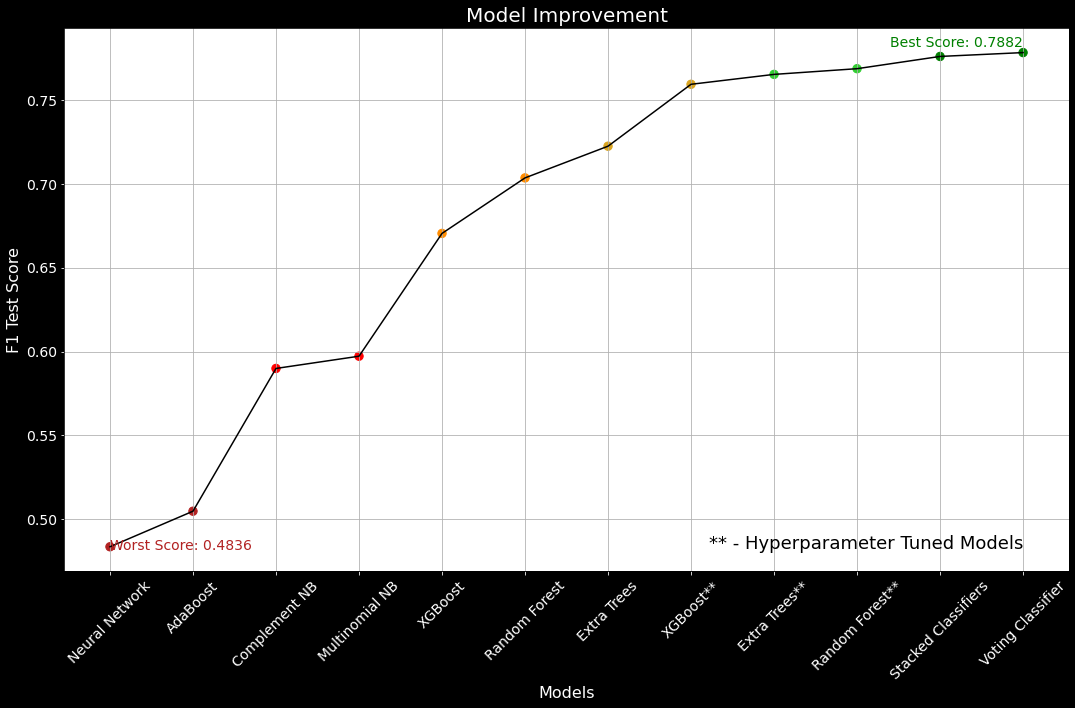

In [137]:
fig, ax = plt.subplots(figsize = (18, 10), facecolor = 'black')
all_models = ['Neural Network', 'AdaBoost', 'Complement NB', 'Multinomial NB', 'XGBoost', 'Random Forest', 'Extra Trees', 'XGBoost**', 'Extra Trees**', 'Random Forest**', 'Stacked Classifiers', 'Voting Classifier']
all_scores = base_scores + final_scores

colors_all = ['firebrick', 'firebrick', 'red', 'red', 'darkorange', 'darkorange', 'goldenrod', 'goldenrod', 'limegreen', 'limegreen', 'green', 'green']
ax.scatter(all_models, all_scores, color = colors_all, marker = 'o', s = 70)
ax.plot(all_models, all_scores, color = 'black')
ax.set_title('Model Improvement', fontsize = 20, color = 'white')
ax.set_xlabel('Models', color = 'white', fontsize = 16)
ax.set_ylabel('F1 Test Score', color = 'white', fontsize = 16)
ax.tick_params(axis = 'x', rotation = 45, colors = 'white', labelsize = 14)
ax.tick_params(axis = 'y', colors = 'white', labelsize = 14)
ax.text('Voting Classifier', 0.78, 'Best Score: 0.7882', color = 'green', ha = 'right', va = 'bottom', fontsize = 14)
ax.text('Neural Network', 0.48, 'Worst Score: 0.4836', color = 'firebrick', ha = 'left', va = 'bottom', fontsize = 14)
ax.text('Voting Classifier', 0.48, '** - Hyperparameter Tuned Models', color = 'black', ha = 'right', va = 'bottom', fontsize = 18)
ax.grid(True)

plt.savefig('Images/total_model_eval.png')
plt.show()

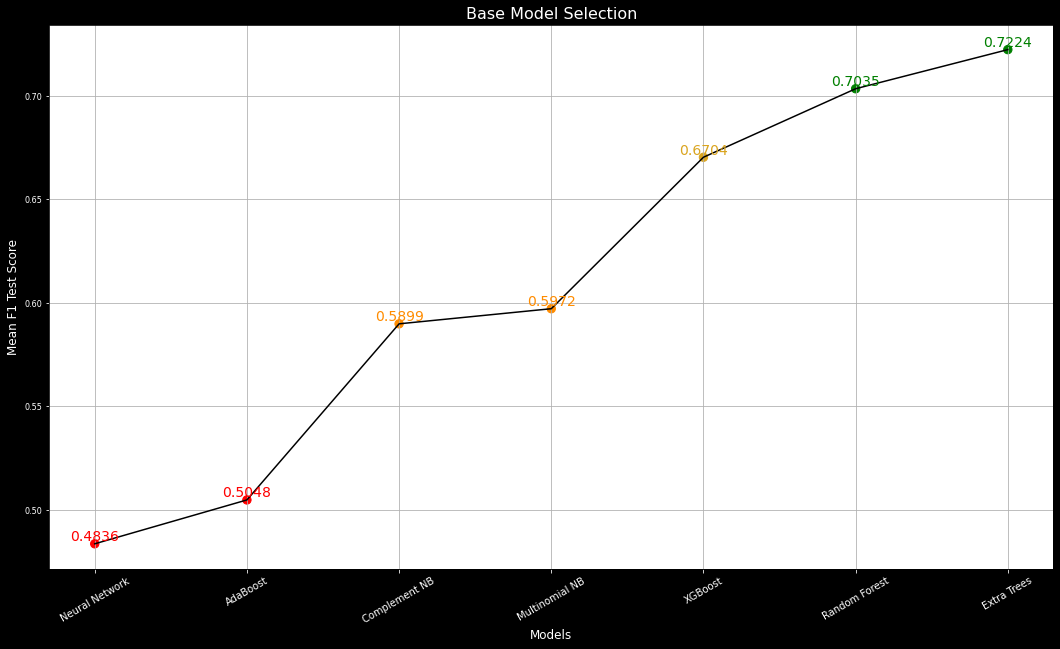

In [105]:
fig, ax = plt.subplots(figsize = (18, 10), facecolor = 'black')
colors_bm = ['red', 'red', 'darkorange', 'darkorange', 'goldenrod', 'green', 'green']
ax.plot(base_models, base_scores, color = 'black')
ax.scatter(base_models, base_scores, color = colors_bm, marker = 'o', s = 70)
ax.set_title('Base Model Selection', color = 'White', fontsize = 16)
ax.set_xlabel('Models', color = 'white', fontsize = 12)
ax.set_ylabel('F1 Test Score', color = 'white', fontsize = 12)
ax.tick_params(axis = 'x', rotation = 30, colors = 'white', labelsize = 10)
ax.tick_params(axis = 'y', colors = 'white', labelsize = 8)
for i, label in enumerate(base_scores):
    ax.text(base_models[i], base_scores[i], label, fontsize = 14, color = colors_bm[i], ha = 'center', va = 'bottom')
ax.grid(True)

plt.savefig('Images/base_model_selection.png')
plt.show()

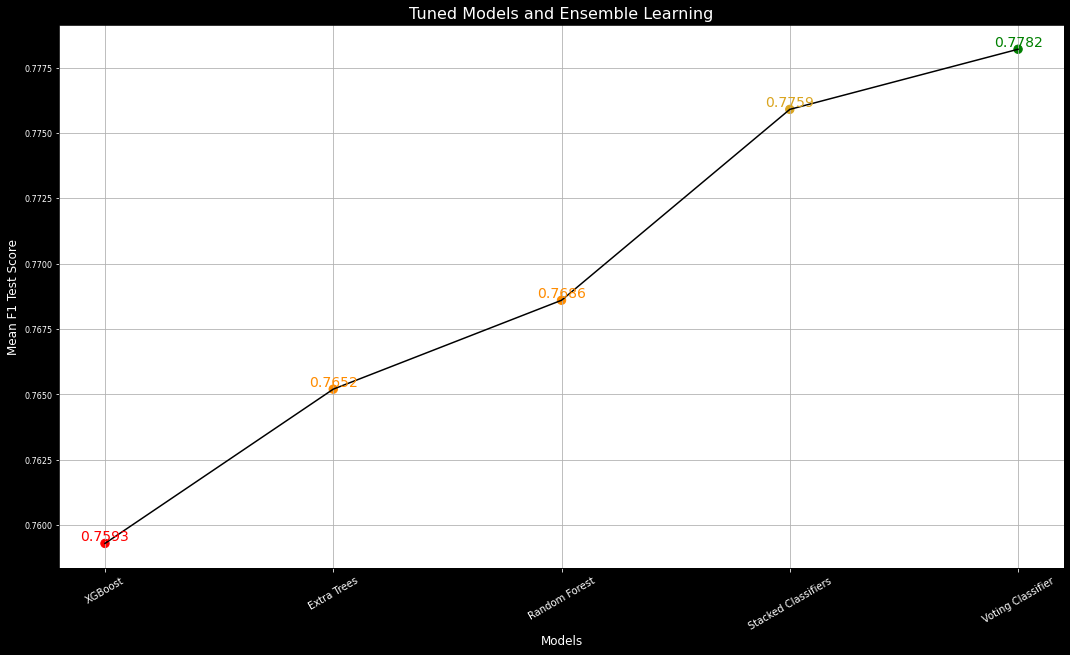

In [110]:
fig, ax = plt.subplots(figsize = (18, 10), facecolor = 'black')
colors_fm = ['red', 'darkorange', 'darkorange', 'goldenrod', 'green']
ax.plot(final_models, final_scores, color = 'black')
ax.scatter(final_models, final_scores, color = colors_fm, marker = 'o', s = 70)
ax.set_title('Tuned Models and Ensemble Learning', color = 'White', fontsize = 16)
ax.set_xlabel('Models', color = 'white', fontsize = 12)
ax.set_ylabel('Mean F1 Test Score', color = 'white', fontsize = 12)
ax.tick_params(axis = 'x', rotation = 30, colors = 'white', labelsize = 10)
ax.tick_params(axis = 'y', colors = 'white', labelsize = 8)
for i, label in enumerate(final_scores):
    ax.text(final_models[i], final_scores[i], label, fontsize = 14, color = colors_fm[i], ha = 'center', va = 'bottom')
ax.grid(True)

plt.savefig('Images/tuned_ensemble.png')
plt.show()

#### Conclusion

Overall, I was able to build and improve a model that scored from 0.4836 all the way up to 0.7782.  Given that there were 5 overall classes and a random guess with no other information would be correct only 20% of the time, an F1 score of 0.7782 is quite strong.